# Part 2: Convolutional neural network

We use the training and evaluation pipeline developed in part 1 to train and evaluate two CNN models.
The first is composed of standard convolutional layers, non-linaerities, and pooling layers of your choice. The second includes skip connections. We implement our own ResidualBlock as a new layer under the nn.Module super-class. 

### Train and apply model

- We train the two models. We also try different values of the hyper-paramter settings. 
- We re-use the functions from model_pipeline.py which we used on MLP models.
- We describe briefly your two models and your hyper-parameter setups and comment on results.
- We also compare the performance of the two models and the three feed forward models using suitable supportive tables and graphs, and complemented by relevant comments.

**Test Accuracy with Best CNN Model: RESNet - 93.13%**

#### Important Note: 
All the CNN file code runs on GPU. Those settings are configured in the backend file model_pipeline.py. While running the cells in this notebook, wherever there is device paramether, please change the parameter according to the OS('cuda' or'cpu') this file is being run on. Right now, it is set to 'mps' since I have Mac OS.

In [9]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
from torch import nn
from scripts.model_pipeline import mlp_train, loss_plot, mlp_apply
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### CNN Model 1: CNN Model with Convolution, Batch Norm and Max Pooling

In [28]:
class CNN_Model1(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(CNN_Model1, self).__init__()
        
        #Convolutional Layers with Batch Norm and Max Pooling
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
                
        #Fully connected layers
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
 
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)  # Flattening the tensor for the fully connected layer
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [29]:
#Parameters
in_features = 28*28    #(1 x 28 x 28 images)
out_features = 10      #10 classes
n_epochs = 20
batch_size = 128
lr = 0.1
momentum = 0
optimizer='SGD'        #Can be 'SGD' or 'Adam' or 'RMSProp'
model_type = 'CNN'

#CNN with 3 Conv1D Layers
model = CNN_Model1(in_channels=1, num_classes=out_features)
device = torch.device('mps') #'mps' for macbook, 'cuda' for windows or 'cpu'
model.to(device)

#Data
trainset = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

# Train and evaluate CNN Model
cnn_model1, train_losses1, test_losses1, train_accuracy1, test_accuracy1 = mlp_train(model, model_type, trainset, 
                                                                                     testset, in_features, 
                                                                                     n_epochs=n_epochs, 
                                                                                     batch_size=batch_size, 
                                                                                     optimizer_param=optimizer, 
                                                                                     optimizer_lr=lr, device=device)
#model: untrained model

print(cnn_model1)

Epoch 1/20, Train Loss: 0.5958, Train Accuracy: 77.6902, Test Loss: 0.3913, Test Accuracy: 85.9869
Epoch 2/20, Train Loss: 0.3688, Train Accuracy: 86.4644, Test Loss: 0.4248, Test Accuracy: 84.6717
Epoch 3/20, Train Loss: 0.3203, Train Accuracy: 88.1180, Test Loss: 0.3124, Test Accuracy: 88.6373
Epoch 4/20, Train Loss: 0.2913, Train Accuracy: 89.0997, Test Loss: 0.2974, Test Accuracy: 88.9339
Epoch 5/20, Train Loss: 0.2727, Train Accuracy: 89.9715, Test Loss: 0.2681, Test Accuracy: 90.1899
Epoch 6/20, Train Loss: 0.2567, Train Accuracy: 90.3240, Test Loss: 0.2448, Test Accuracy: 90.9909
Epoch 7/20, Train Loss: 0.2425, Train Accuracy: 90.9526, Test Loss: 0.2453, Test Accuracy: 90.9513
Epoch 8/20, Train Loss: 0.2314, Train Accuracy: 91.4429, Test Loss: 0.2874, Test Accuracy: 89.4086
Epoch 9/20, Train Loss: 0.2227, Train Accuracy: 91.6561, Test Loss: 0.2753, Test Accuracy: 89.8932
Epoch 10/20, Train Loss: 0.2140, Train Accuracy: 92.1325, Test Loss: 0.2291, Test Accuracy: 91.7029
Epoch 11/

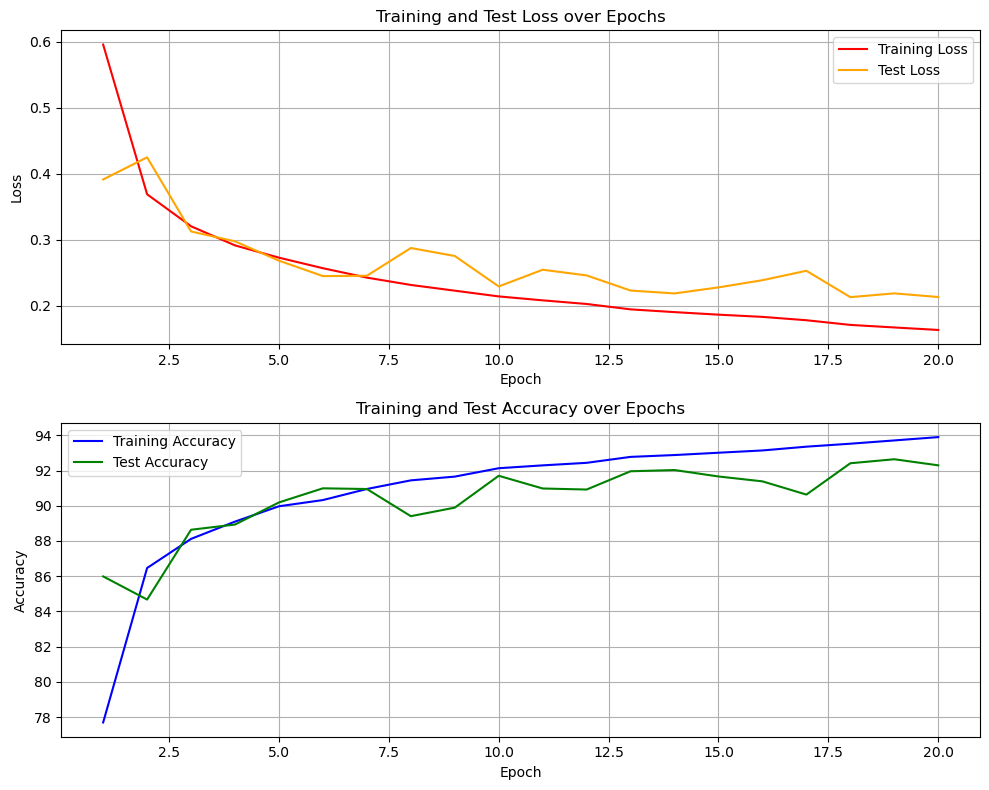

In [31]:
loss_plot(train_losses1,test_losses1,train_accuracy1,test_accuracy1,n_epochs)

### CNN Model 2: With Residual Block 

#### Residual Block Class:
- 2 Convolution Layers with Batch Norms after each
- Dropout
- Relu

In [33]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        
        #Convolutional Layers with Batch Norm and ReLU
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding='same')
        self.bn2 = nn.BatchNorm2d(out_channels)
         
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        ##for residual addition
        self.res = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, padding='valid')
    

    def forward(self, x):
        
        #Main path
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.pool(self.bn2(self.conv2(out)))
        x = self.res(x)
        out = out + x
        out = self.relu(out)         
        
        return out

#### CNN Model Class:
- Convolution Layer with Batch Norm and Max Pooling
- Residual Block 1
- Residual Block 2
- Average Pooling Layer
- Fully Conected Layer 

In [36]:
class CNN_Model2(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(CNN_Model2, self).__init__()
        
        #Convolutional Layer with Batch Norm and Pooling
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding='same')
        self.bn1 = nn.BatchNorm2d(32)

        #Residual Blocks with Pooling
        self.resblock1 = ResidualBlock(32, 64)
        self.resblock2 = ResidualBlock(64, 64)
        
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.2)
        
        #Fully Connected Layers      
        self.fc = nn.Linear(576, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.resblock1(x)
        x = self.resblock2(x)        
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flattening the tensor for the fully connected layer
        x = self.fc(x)
        
        return x

In [37]:
#Parameters
in_features = 28*28    #(1 x 28 x 28 images)
out_features = 10      #10 classes
n_epochs = 20
batch_size = 128
lr = 0.1
momentum = 0
optimizer='SGD'        #Can be 'SGD' or 'Adam' or 'RMSProp'
model_type = 'CNN'

#Data
trainset = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(),)
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)

#Model
model = CNN_Model2(in_channels=1, num_classes=out_features)
device = torch.device("mps")   #'mps' for macbook, 'cuda' for windows or 'cpu'
model.to(device)

#Train and evaluate the model
cnn_model2, train_losses2, test_losses2, train_accuracy2, test_accuracy2 = mlp_train(model, model_type, trainset, 
                                                                                     testset, n_epochs=n_epochs, 
                                                                                     batch_size=32, 
                                                                                     optimizer_param=optimizer, 
                                                                                     optimizer_lr=lr, device=device)
print(cnn_model2)

Epoch 1/20, Train Loss: 0.3923, Train Accuracy: 85.6550, Test Loss: 0.2835, Test Accuracy: 89.7664
Epoch 2/20, Train Loss: 0.2572, Train Accuracy: 90.7350, Test Loss: 0.2417, Test Accuracy: 91.2839
Epoch 3/20, Train Loss: 0.2234, Train Accuracy: 91.9633, Test Loss: 0.2335, Test Accuracy: 91.4537
Epoch 4/20, Train Loss: 0.2038, Train Accuracy: 92.5717, Test Loss: 0.2437, Test Accuracy: 91.2839
Epoch 5/20, Train Loss: 0.1849, Train Accuracy: 93.2617, Test Loss: 0.2260, Test Accuracy: 92.0228
Epoch 6/20, Train Loss: 0.1721, Train Accuracy: 93.6117, Test Loss: 0.2110, Test Accuracy: 92.7117
Epoch 7/20, Train Loss: 0.1577, Train Accuracy: 94.2483, Test Loss: 0.2087, Test Accuracy: 92.8115
Epoch 8/20, Train Loss: 0.1479, Train Accuracy: 94.6833, Test Loss: 0.2053, Test Accuracy: 93.0012
Epoch 9/20, Train Loss: 0.1389, Train Accuracy: 94.8700, Test Loss: 0.1993, Test Accuracy: 93.1310
Epoch 10/20, Train Loss: 0.1338, Train Accuracy: 95.1783, Test Loss: 0.2132, Test Accuracy: 92.8315
Epoch 11/

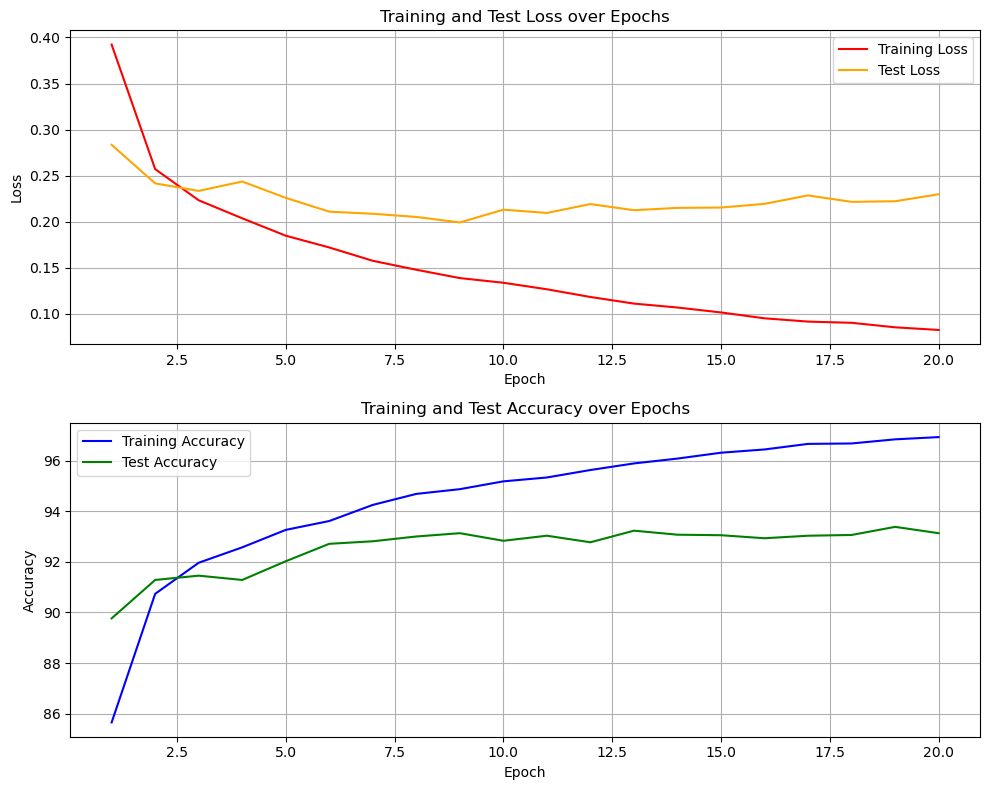

In [38]:
loss_plot(train_losses2,test_losses2,train_accuracy2,test_accuracy2,n_epochs)

In [39]:
best_model = cnn_model2

### Model application

Defined a simple utility function `mlp_apply` in /scripts/model_pipeline.py that uses the train model to classify 10 examples of the test set and displays the 10 images in a grid together with their true and predicted labels.

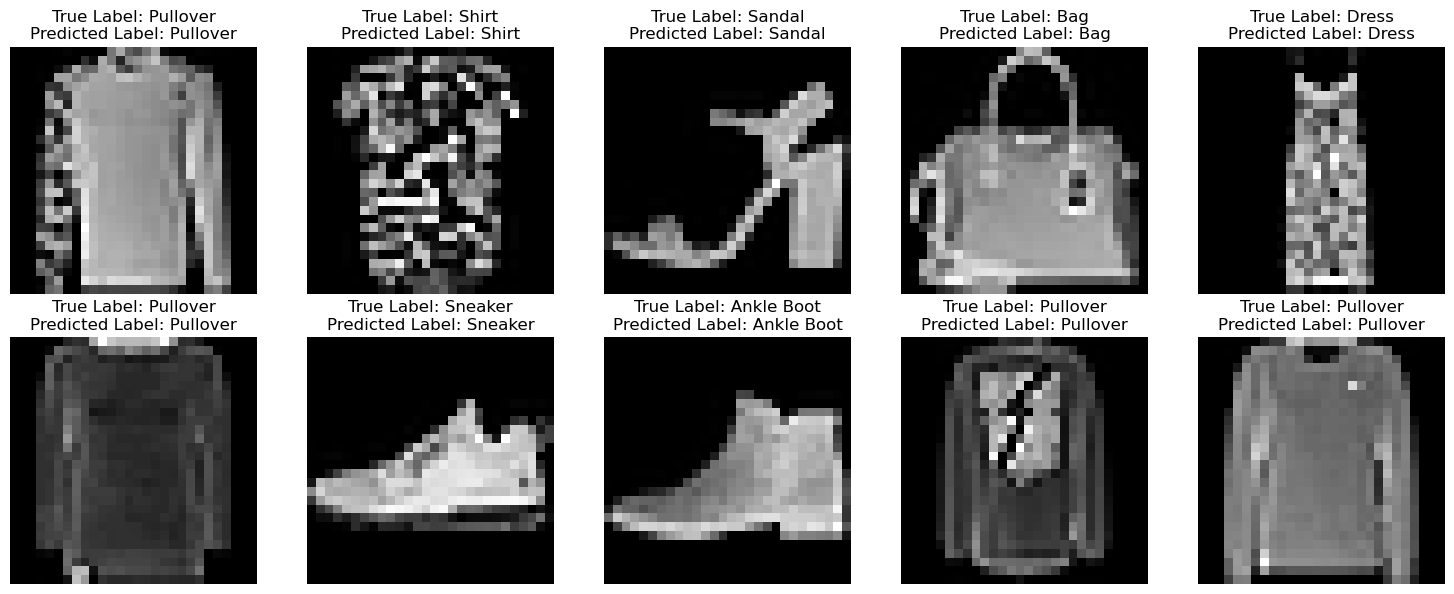

In [43]:
from scripts.model_pipeline import mlp_apply

#user parameters
test_indexes = torch.randint(0, 10000, (10,))  # list of 10 indexes - examples to extract from test set
testset = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(),)
model_type = 'CNN'

#Doing these sample predictions on CPU
device = torch.device('cpu')
best_model.to(device)

mlp_apply(best_model, model_type, testset, test_indexes)

### Model Descriptions and Comparison ---->

### CNN Model 1: CNN with Max Pooling, Batch Norm and ReLU 

This model reaches test accuracy **92.29%** in the 20th epoch. It consists of three convolutional blocks followed by fully connected layers. Each convolutional block includes a convolutional layer, batch normalization, an activation function (ReLU), and max pooling. We also include Dropout layers. The fully connected layers reduce the feature maps to class scores.

Hyperparameters:
- Opimiser: SGD
- Learning rate: 0.1
- epochs = 20
- batch size = 128
- Dropout rate = 0.2

Model Architecture:
- Input: 1 channel (e.g., grayscale image)
- Conv2d Block 1
    - Convolutional Layer: (1 -> 32, 3x3 kernel, stride 1, padding 1)
    - Batch Normalization: (32 features)
    - ReLU Activation
    - Max Pooling: (2x2 kernel, stride 2)
- Conv2d Block 2
    - Convolutional Layer: (32 -> 64, 3x3 kernel, stride 1, padding 1)
    - Batch Normalization: (64 features)
    - ReLU Activation
    - Max Pooling: (2x2 kernel, stride 2)
- Conv2d Block 3
    - Convolutional Layer: (64 -> 128, 3x3 kernel, stride 1, padding 1)
    - Batch Normalization: (128 features)
    - ReLU Activation
    - Max Pooling: (2x2 kernel, stride 2)
- Fully Connected Block
    - Linear Layer: (1152 -> 256)
    - ReLU Activation
    - Dropout: (p=0.2)
    - Linear Layer: (256 -> 10)

### CNN Model 2: Includes Residual Block

This model reaches the accuracy of **93.13%** in the 20th epoch. This model enables the training of the deep neural network by using residual learning and shortcut connections. We create a residual block class from nn.Module, and call these res-blocks in our main CNN architecture. We use SGD Optimiser.

Hyperparameters:
- Opimiser = SGD
- Learning rate = 0.1
- epochs = 20
- batch size = 128
- Dropout rate = 0.2


Model Architecture:

**Residual Block**: 
- Convolutional Layer 1: (32 -> 64, 3x3 kernel, stride 1, padding 'same')
- Batch Normalization: (64 features)
- ReLU Activation
- Convolutional Layer 2: (64 -> 64, 3x3 kernel, stride 1, padding 'same')
- Batch Normalization: (64 features)
- ReLU Activation
- Dropout: (p=0.2)
- Max Pooling: (2x2 kernel, stride 2)
- Residual Connection: (32 -> 64, 1x1 kernel, stride 2, padding 'valid')

**CNN Model:**
- Input: 1 channel (e.g., grayscale image)
    - Conv2d Block
    - Convolutional Layer: (1 -> 32, 3x3 kernel, stride 1, padding 'same')
    - Batch Normalization: (32 features)
    - ReLU Activation
- Residual Block 1
- Residual Block 2
- Average Pooling
    - Avg Pooling: (2x2 kernel, stride 2)
- Fully Connected Block
    - Dropout: (p=0.2)
    - Linear Layer: (576 -> 10)
    - ReLU Activation

### Loss Comparison:

- The model 1 gives a loss of **0.21** in the 20th epoch, which is much lesser than the mlp models. This model starts with a high loss but then the loss decreases eventually.  
- Model 2 results in a loss of **0.22** which is comparable to the loss of Model 1. In this model, we use Residual Blocks/skip connections, so that the input is added again after every resblock. 
- We can see from the graph that this model starts with a lower loss compared to model 1 and then has few spikes in the later epochs. And at last epoch, both models result in similar loss.

In [40]:
n_epochs = 20
epochs = list(range(1, n_epochs+1))

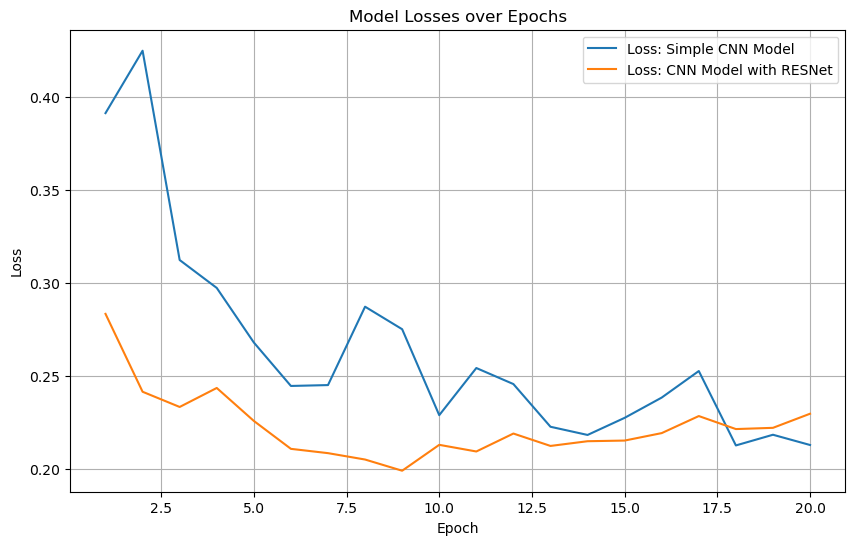

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_losses1, label='Loss: Simple CNN Model')
plt.plot(epochs, test_losses2, label='Loss: CNN Model with RESNet')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Losses over Epochs')
plt.legend()
plt.grid(True)

plt.show()

### Accuracy Comparison

- Model 1 has **92.29**% test accuracy, which is lower than the accuracy achieved by ResNet Model 2. 
- In order to further increase the accuracy, Model 2 uses a Residual Block, we achieve **93.13%** test accuracy. 
- Model 2 always has high test accuracy than Model 1, since we use Residual blocks.

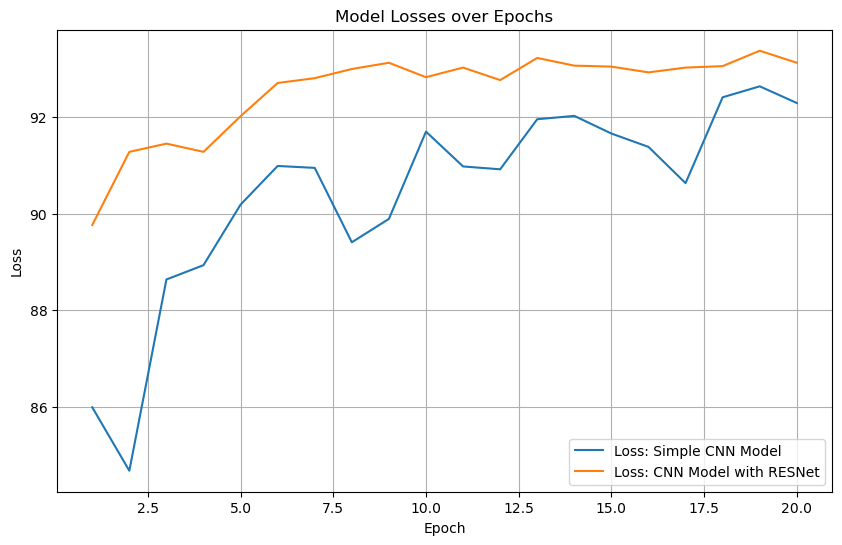

In [42]:
plt.figure(figsize=(10, 6))

plt.plot(epochs, test_accuracy1, label='Loss: Simple CNN Model')
plt.plot(epochs, test_accuracy2, label='Loss: CNN Model with RESNet')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Losses over Epochs')
plt.legend()
plt.grid(True)

plt.show()

### Comparison with Feed Forward Neural Networks ----->



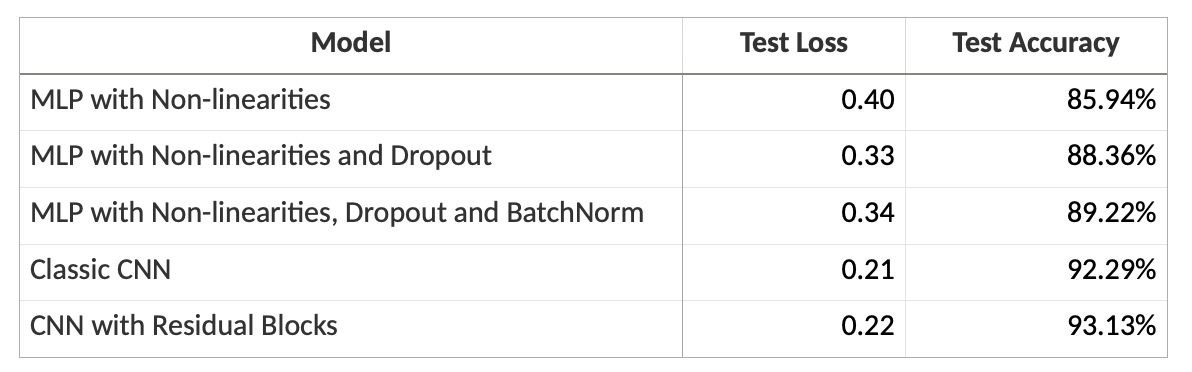

The above table compares the accuracy and loss on test data of Multi-Layer Perceptrons models with Convolutional Neural Networks models.

#### Models:
- MLP with Non-linearities:
  This model uses basic MLP architecture with non-linear activation functions.

- MLP with Non-linearities and Dropout:
  This MLP model includes dropout layers, which help in reducing overfitting by randomly dropping units during training.

- MLP with Non-linearities, Dropout, and BatchNorm:
  This model further improves the basic MLP by adding batch normalization layers, which stabilize and accelerate the training process.

- Classic CNN:
  This is a standard convolutional neural network that uses convolutional layers to capture local features in data.

- CNN with Residual Blocks:
  This advanced CNN architecture incorporates residual blocks, which helps to solve the vanishing gradient problem.

#### Comparison Insights:
**Predictions**: The best CNN model performs well on test data. The section where we apply the mlp_apply function, we see that all the true labels match the predicted labels, as opposed to the MLP model where it does 9 correct predictions.

**Accuracy:**
- The Classic CNN and CNN with Residual Blocks outperform the MLP models in terms of test accuracy. The highest accuracy is achieved by the CNN with Residual Blocks at **93.13%**, followed closely by the Classic CNN at **92.29%**.
- Among the MLP models, adding dropout and batch normalization increases the accuracy, with the MLP having both dropout and batch normalization achieving the highest accuracy of **89.2%**.

**Loss:**
- The test loss follows a similar pattern, with CNN models having lower test losses compared to MLP models. The Classic CNN has the lowest test loss at 0.21, while the CNN with Residual Blocks has a slightly higher loss at 0.22.
- For the MLP models, the addition of dropout reduces the test loss from 0.40 to 0.33. However, the test loss slightly increases to 0.34 when batch normalization is added.

#### Conclusion:
Overall, the CNN models significantly outperform the MLP models in both test accuracy and test loss. The advanced CNN with Residual Blocks shows the best performance. CNNs are good for image data because they work on local features and understand patterns. The improvements in the MLP models with dropout and batch normalization show the importance of these techniques in increasing the model's generalization capabilities.